In [1]:
import glob
import os.path
import sqlite3

import numpy as np
import matplotlib.pyplot as plt
import datetime
import json
import pandas as pd
from scipy.optimize import minimize 
from pycparser import ply

In [2]:
def read_json_metadata(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
        
    time = []
    integration = []
    wavelength = []
    intensity = []
    for d in data:
        dt = datetime.datetime(*[int(t) for t in d['AbsTime']])
        unix_timestamp = int(dt.timestamp())
        tau = float(d['ExpTime'])
        lam = int(d['Wavelength'])
        intense = float(d['AvgInt'])
        time.append(unix_timestamp)
        integration.append(tau)
        wavelength.append(lam)
        intensity.append(intense)
        
    indices = np.argsort(wavelength)
    return (np.asarray(time)[indices], 
            np.asarray(integration)[indices], 
            np.asarray(wavelength)[indices], 
            np.asarray(intensity)[indices],
            indices)

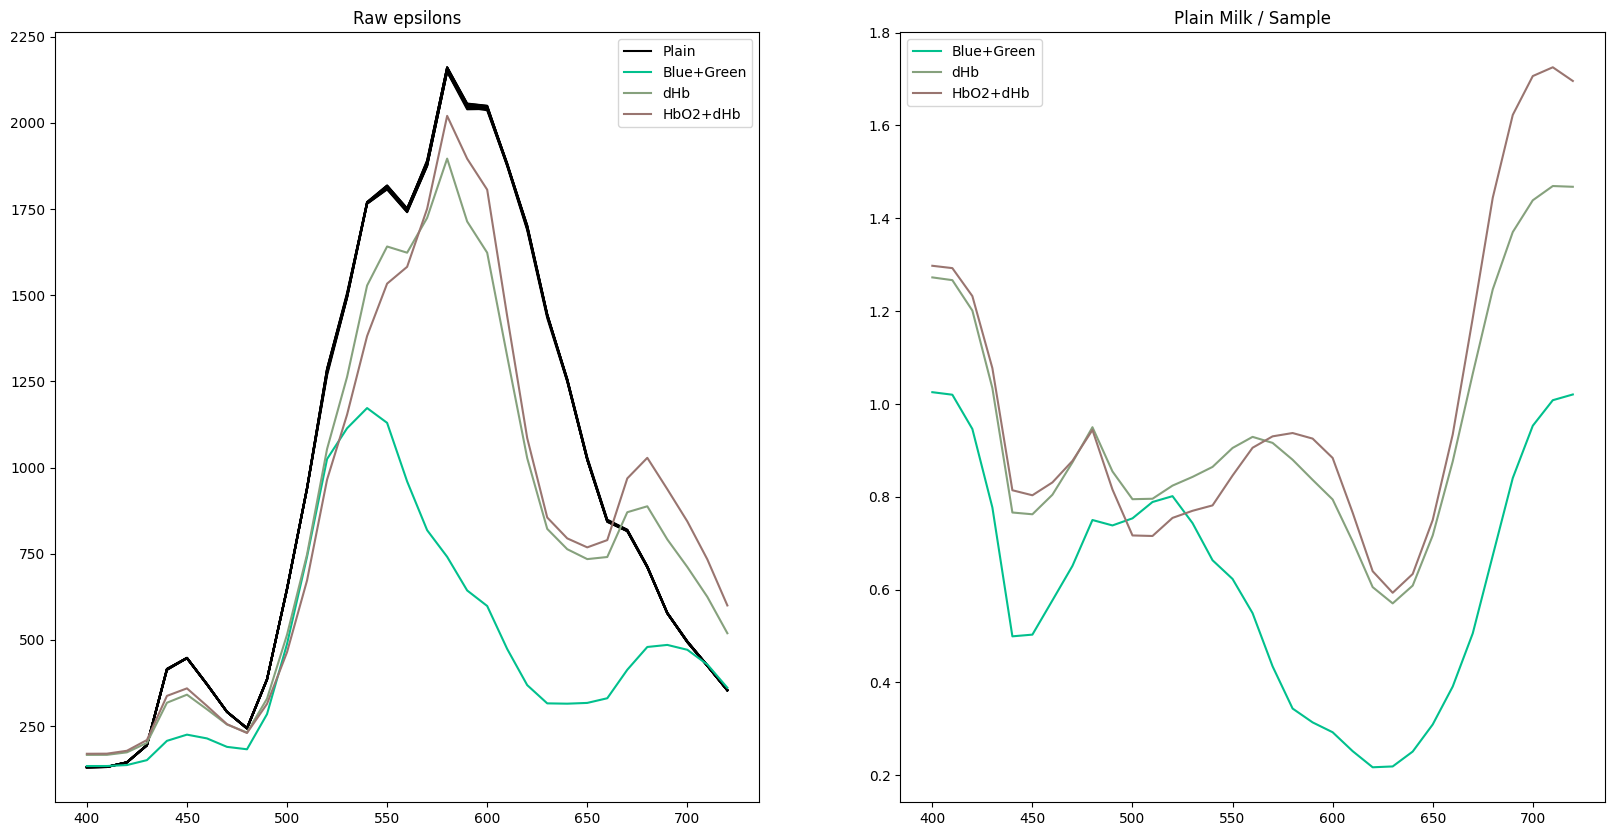

In [3]:
milk_paths = {'Plain': [r'D:\Jesse\phatnoms_02172025\milk', 'k'],
              'Blue+Green': [r'D:\Jesse\phatnoms_02172025\blue25_green25', 'xkcd:green/blue'],
              'dHb': [r'D:\Jesse\phatnoms_02172025\red25_yellow25_blue_10', 'xkcd:grey/green'],
              'HbO2+dHb': [r'D:\Jesse\phatnoms_02172025\red50_yellow25_blue10_green10', 'xkcd:reddish grey']
              }

fig = plt.figure(figsize = (20,10))
raw_ax = plt.subplot(121)
diff_ax = plt.subplot(122)
out_data = {}
for label, (path, c) in milk_paths.items():
    raw_ax.plot([], [], label=label, color=c)
    if 'Plain' in out_data:
        diff_ax.plot([], [], label=label, color=c)
    intensities = []
    for cycle in os.listdir(path):
        # Load settings data
        metadata_file = glob.glob(os.path.join(path, cycle, '*metadata.json'))[0]
        tim, integration, wavelength, intensity, indices = read_json_metadata(metadata_file)
        intensities.append(intensity)
        raw_ax.plot(wavelength, intensity, color=c)
        if 'Plain' in out_data:
            diff_ax.plot(wavelength, intensity / out_data['Plain'] , color=c)
    intensity = np.mean(intensities, axis=0)
    out_data[label] = intensity
raw_ax.legend()
raw_ax.set_title('Raw epsilons')
diff_ax.legend()
diff_ax.set_title('Plain Milk / Sample')
plt.show()

In [7]:
def read_spectra(filepath, name=None, concentration=None):
    spectrum = pd.read_table(filepath, header=None, names=['Wavelength', 'Absorption', 'Color'])
    spectrum['Color'] = name if name else filepath.split(os.sep)[-1].split('.')[0]
    spectrum['Concentration'] = concentration if concentration else None
    return spectrum

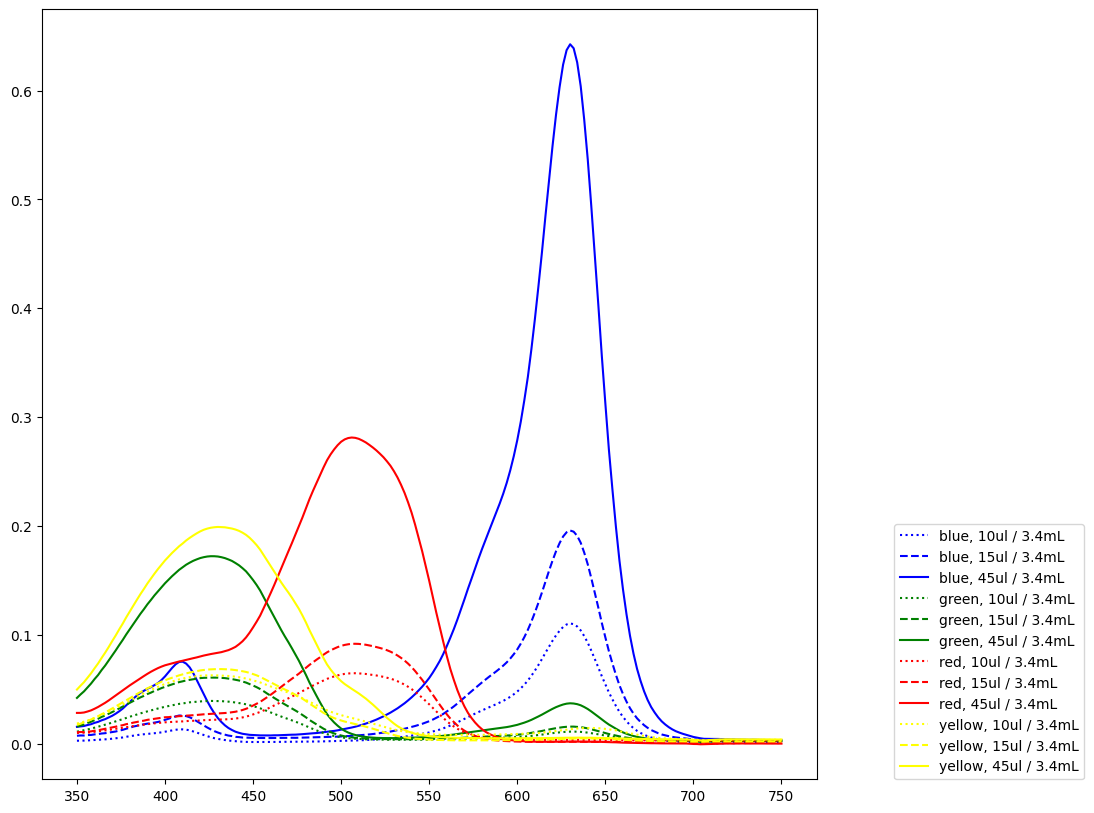

In [8]:
root_dir = r'G:\IVERS_FOOD_COLORING'
txt_files = glob.glob(os.path.join(root_dir, 'DataPoints_*_AbsTSpec.txt'))
colors = [filepath.split(os.sep)[-1].split('.')[0].split('_')[1] for filepath in txt_files]
concs = [filepath.split(os.sep)[-1].split('.')[0].split('_')[2] for filepath in txt_files]
fig = plt.figure(figsize = (10,10))
ax = plt.axes()
linespec = {'10ul': ':',
            '15ul': '--',
            '45ul': '-'
            }
conn = sqlite3.connect(r'C:\Users\jdivers\PycharmProjects\df_image_analysis\databases\hsdfm_data.db')
c = conn.cursor()
c.execute("""DROP TABLE IF EXISTS food_coloring_spectra""")
for filepath, color, conc in zip(txt_files, colors, concs):
    spectrum = read_spectra(filepath, color, conc)
    ax.plot(spectrum['Wavelength'], spectrum['Absorption'], label=f'{color}, {conc} / 3.4mL', color=color, linestyle=linespec[conc])
    spectrum.to_sql('food_coloring_spectra', conn, if_exists='append')
ax.legend(loc=(1.1, 0))
plt.show()

In [9]:
spectra = pd.read_sql("SELECT * FROM food_coloring_spectra", conn)

In [18]:
def plot_mix(composition, ax, wave_range=None, plt_raw=False, label=None, color=None):
    wave_range = (-float('inf'), float('inf')) if wave_range is None else wave_range
    one_part = sum([c for _, c in composition])
    # Filter the appropriate data out
    data = [
        spectra[['Absorption', 'Wavelength']].loc[(spectra['Color'] == color) 
                                                         & (spectra['Concentration'] == '45ul') 
                                                         & (spectra['Wavelength'] >= wave_range[0]) 
                                                         & (spectra['Wavelength'] <= wave_range[1])] 
        for (color, conc) in composition
    ]
    absorption = [conc * d['Absorption'] / one_part for (_, conc), d in zip(composition, data)]
    # return absorption
    if plt_raw:
        for i, a in enumerate(absorption):
            ax.plot(data[0]['Wavelength'], a, color=composition[i][0], linestyle='--')
    absorption = np.sum(absorption, axis=0)
    ax.plot(data[0]['Wavelength'], absorption, label=label, color=color if color is not None else 'k' if plt_raw else None)

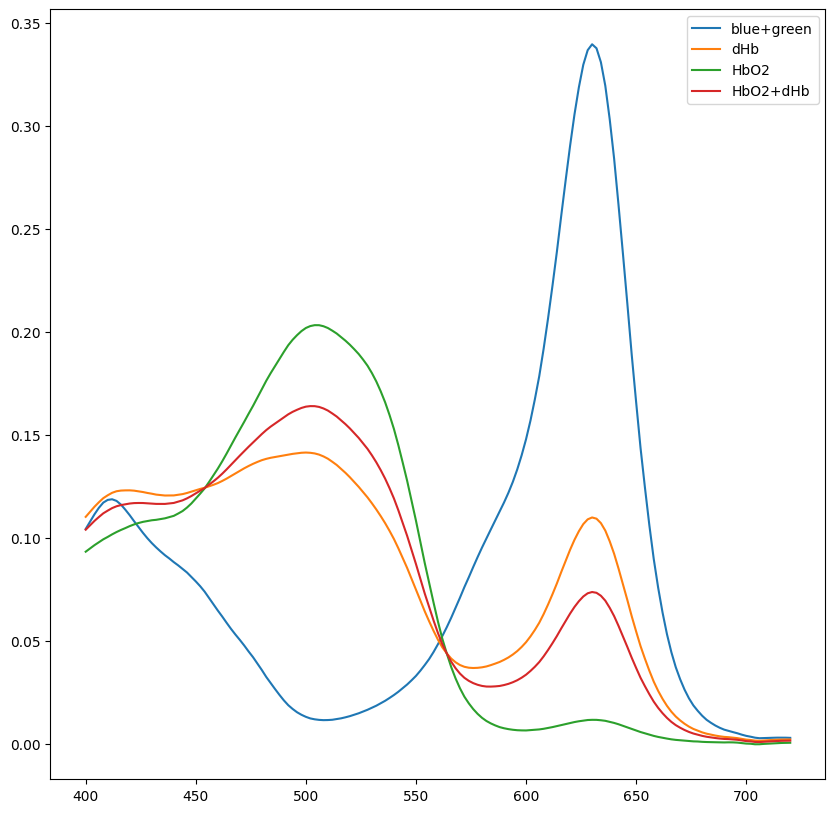

In [19]:
mixes = {'blue+green': [('blue', 50), ('green', 50)],
         'dHb': [('yellow', 25), ('red', 25), ('blue', 10)],
         'HbO2':  [('red', 25), ('green', 10)]}
mixes['HbO2+dHb'] = mixes['dHb'] + mixes['HbO2']
fig = plt.figure(figsize = (10,10))
ax = plt.axes()
for name, makeup in mixes.items():
    plot_mix(makeup, ax, label=name, color=None, wave_range=(400, 720))
ax.legend()
plt.show()

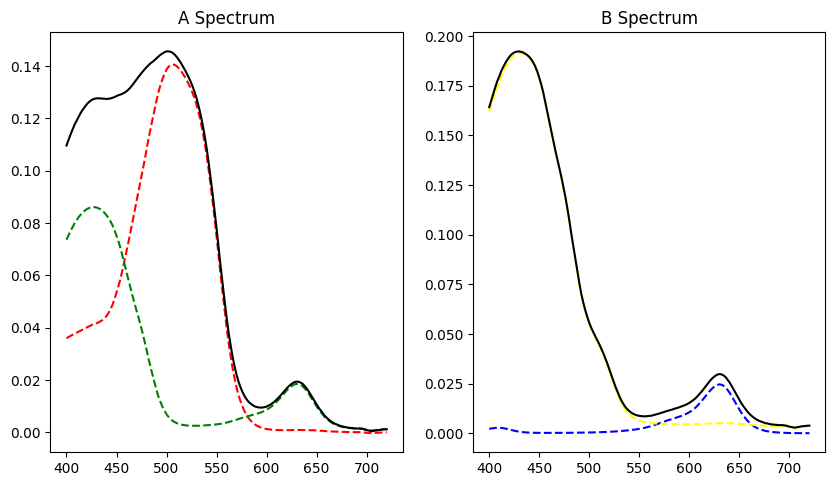

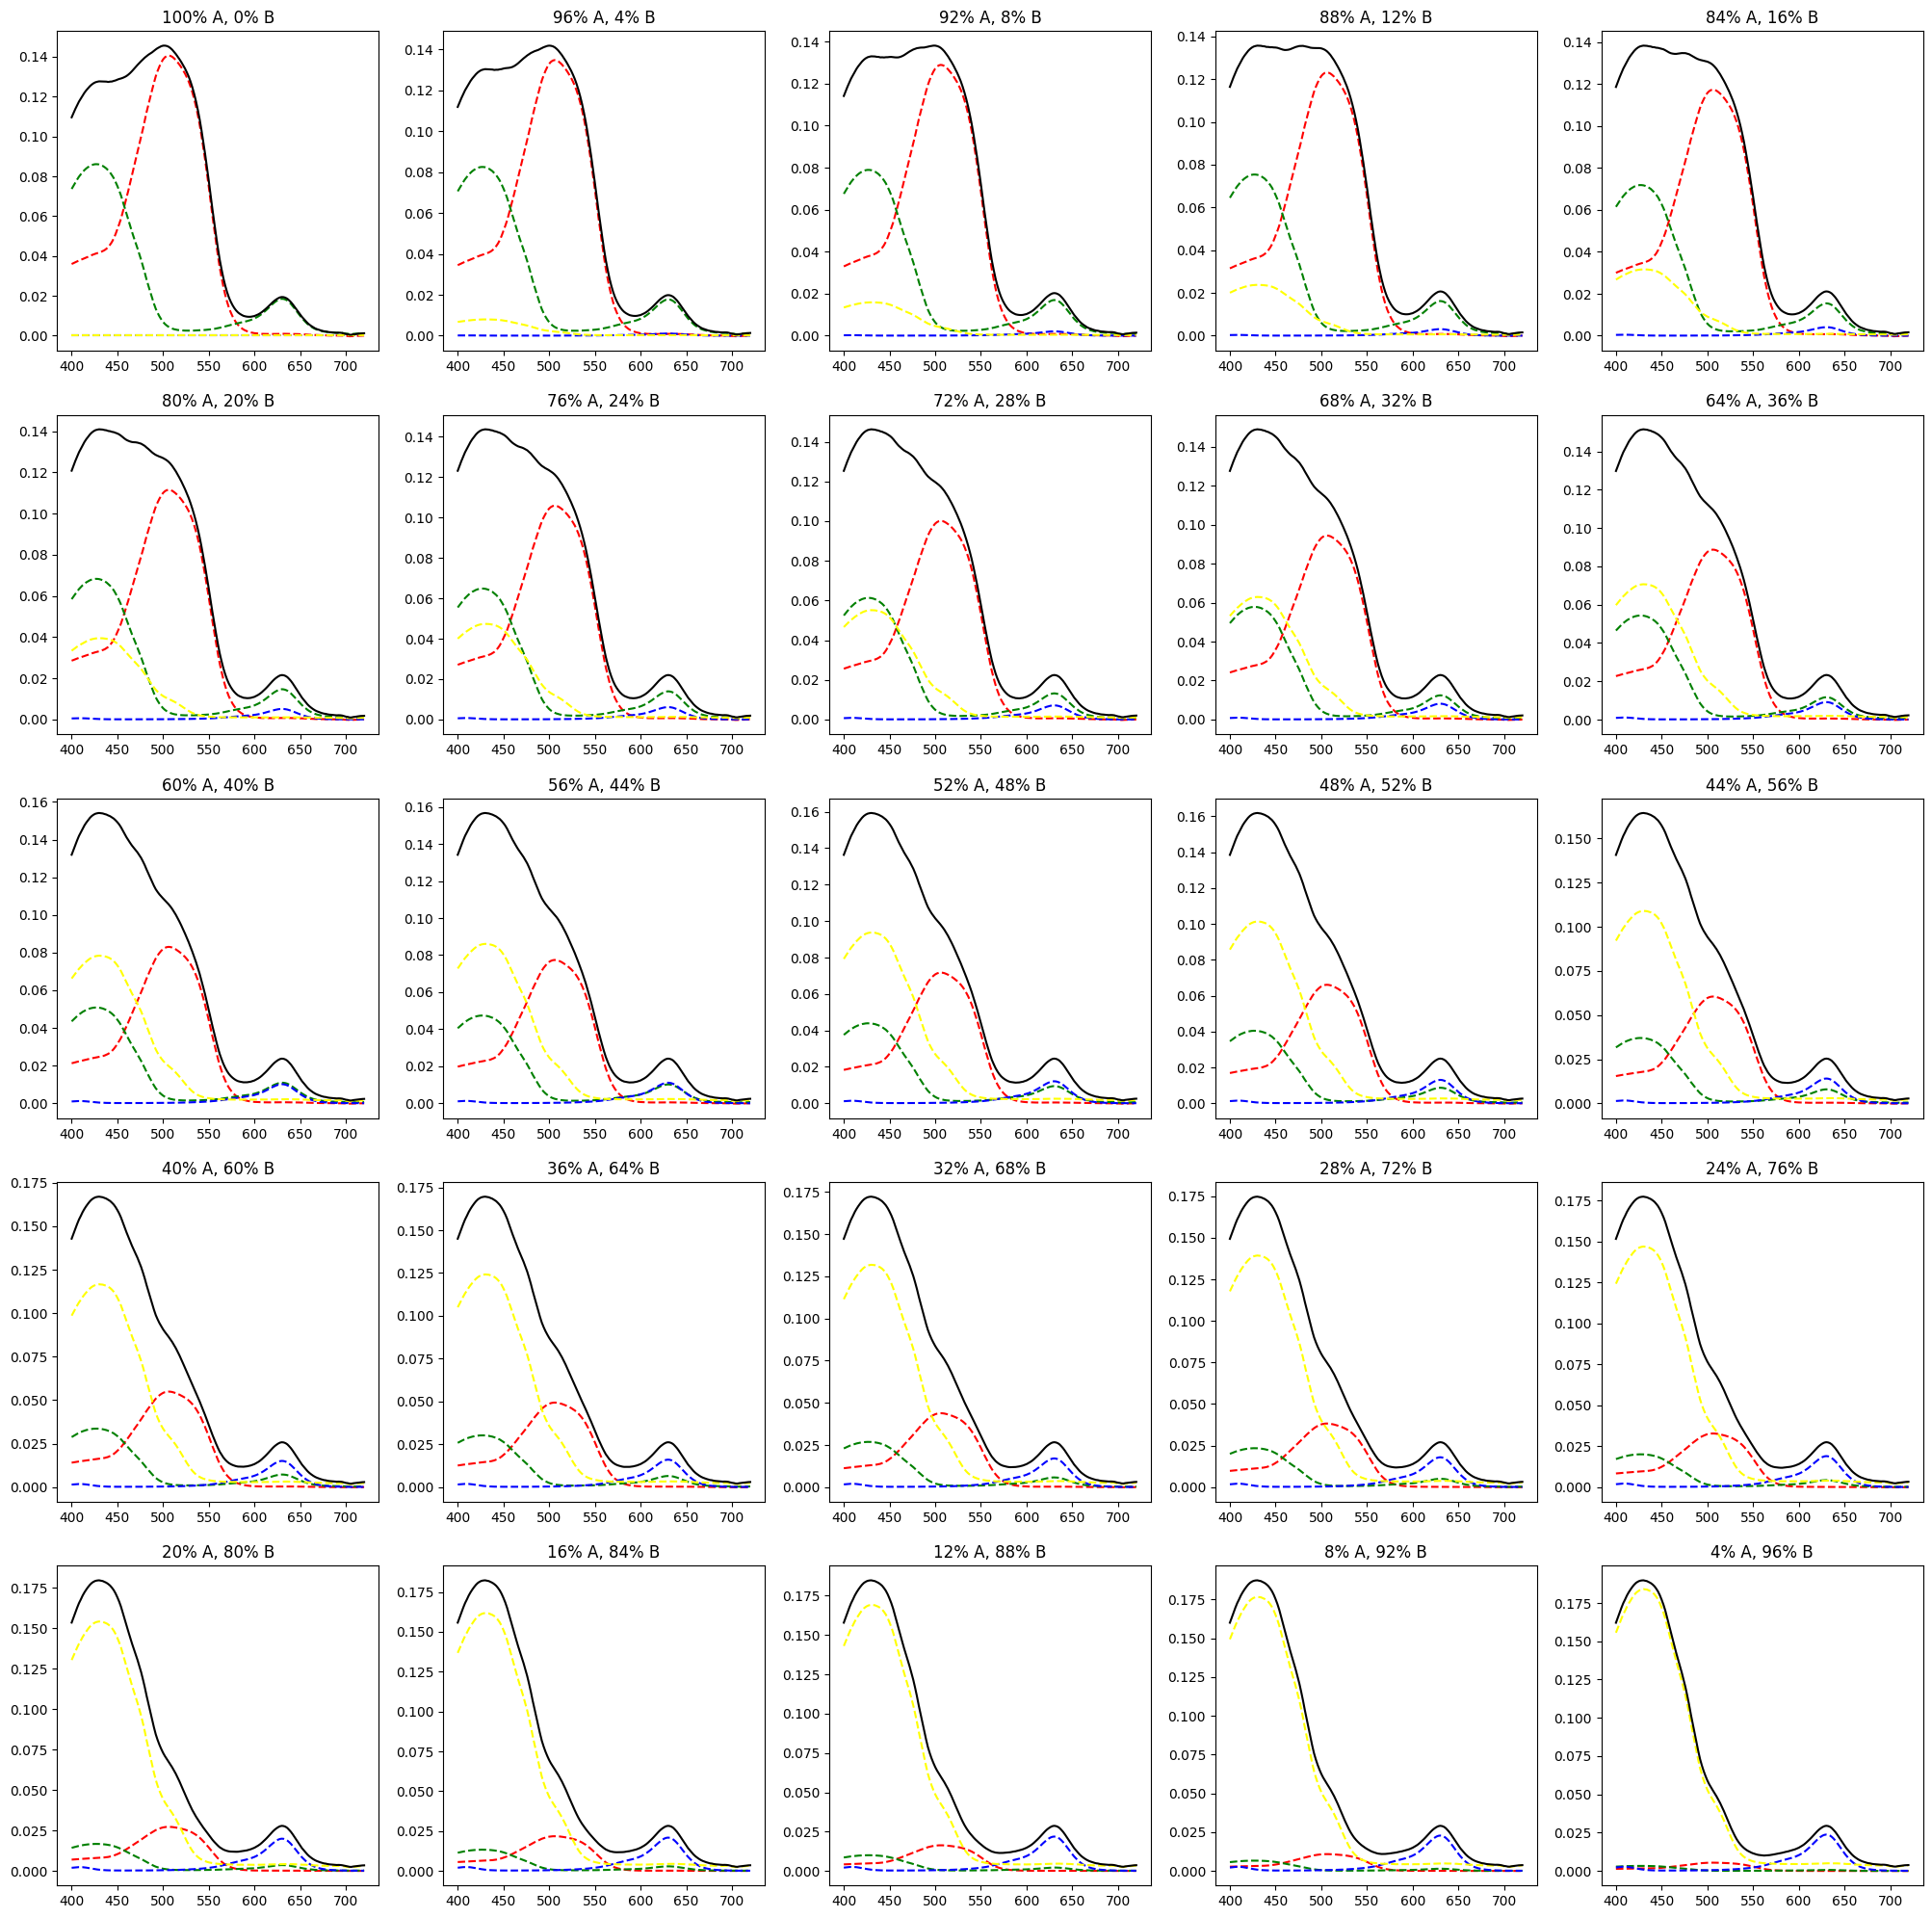

In [30]:
## Testing mixes for future imaging
fig = plt.figure(figsize = (10,12))
# HbO2
ax = plt.subplot(2, 2, 1)
ax.set_title('A Spectrum')
hbo2 = [('red', 25), ('green', 25)]
plot_mix(hbo2, ax, plt_raw=True, wave_range=(400, 720))

# dHb
ax = plt.subplot(2, 2, 2)
ax.set_title('B Spectrum')
dhb = [ ('blue', 2), ('yellow', 50)]
plot_mix(dhb, ax, plt_raw=True,  wave_range=(400, 720))
plt.show()
# 100 - 0% spO2
fig, axes = plt.subplots(5, 5, figsize = (25,25))
for ii in range(100, 0, -4):
    r = int(((100 - ii) / 4) // 5)
    c = int(((100 - ii) / 4) % 5)
    hbo2_per = ii / 100
    dhb_per = 1 - hbo2_per
    ax = axes[r, c]
    ax.set_title(f'{100 * hbo2_per:0.0f}% A, {100 * dhb_per:0.0f}% B')
    spo2_75 = [(color, hbo2_per * conc) for (color, conc) in hbo2] + [(color, dhb_per * conc) for (color, conc) in dhb]
    plot_mix(spo2_75, ax, plt_raw=True, wave_range=(400, 720))
plt.show()

To convert the relative plots into absolute plots in order to re-create them and image, we need to scale everything relative to the original concentration. Mixes are being ploted against the 45$\mu$L concentration. Which was created by adding 5$\mu$L of food coloring to 3 mL of water, then adding 45 $\mu$L of this solution to 3.4 mL of water. 

$$
c_i = \frac{45\times10^{-3} \text{ mL}}{3.4 \text{ mL}}\frac{5 \times 10 ^{-3} \text{ mL}}{3 \text{ mL}} = 22.06 \times 10^{-6} \frac{V_\text{food coloring}}{V_\text{water}}
$$

In [34]:
ci = (45e-3 * 5e-3) / (3.4 * 3)

To make a simple stock solution, we can add $\left(N \times 22 \times C\right)\mu$L of food coloring to $N$ mL of milk. $N$ is the total volume of stock needed and $C$ is how much the absopriton needs to be scaled relative to the original absorption measurements, as determined graphically below. This will yield a stock conentration of $22C \times 10^{-3} \frac{V_\text{food coloring}}{V_\text{milk}}$. To create the 100% spectra phantoms, we simply add $k\mu$L of the stock to $k$mL of milk, dilution by a factor of $10^3$ again, yielding a final concentration of $22C \times 10^{-6} \frac{V_\text{food coloring}}{V_\text{milk}}$. These 100% solutions can be used to create the fractional solutions. If each phantom is $J$mL total, the A fraction is given by $j_A / J$, and $J = j_A + j_B$. The serial dilutions of A can be achieved by taking out some volume of A and replacing it serially with the same volume of B. In practice, this will never totally reach a dilution of 100% B, so an alternative approach is to create seperate solutions of increasing amounts of B. 

In [21]:
def plot_mix_absolute(composition, ax, wave_range=None, plt_raw=False, label=None, color=None):
    wave_range = (-float('inf'), float('inf')) if wave_range is None else wave_range
    # Filter the appropriate data out
    data = [
        spectra[['Absorption', 'Wavelength']].loc[(spectra['Color'] == color) 
                                                         & (spectra['Concentration'] == '45ul') 
                                                         & (spectra['Wavelength'] >= wave_range[0]) 
                                                         & (spectra['Wavelength'] <= wave_range[1])] 
        for (color, conc) in composition
    ]
    absorption = [conc * d['Absorption'] for (_, conc), d in zip(composition, data)]
    # return absorption
    if plt_raw:
        for i, a in enumerate(absorption):
            ax.plot(data[0]['Wavelength'], a, color=composition[i][0], linestyle='--')
    absorption = np.sum(absorption, axis=0)
    ax.plot(data[0]['Wavelength'], absorption, label=label, color=color if color is not None else 'k' if plt_raw else None)

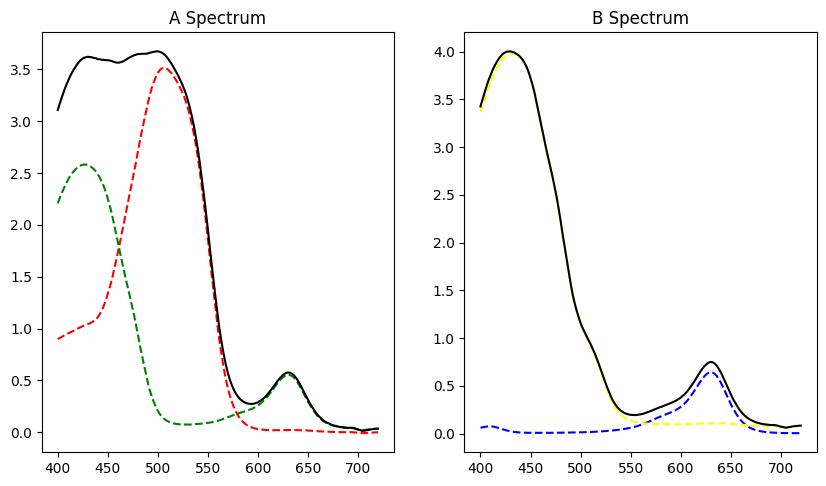

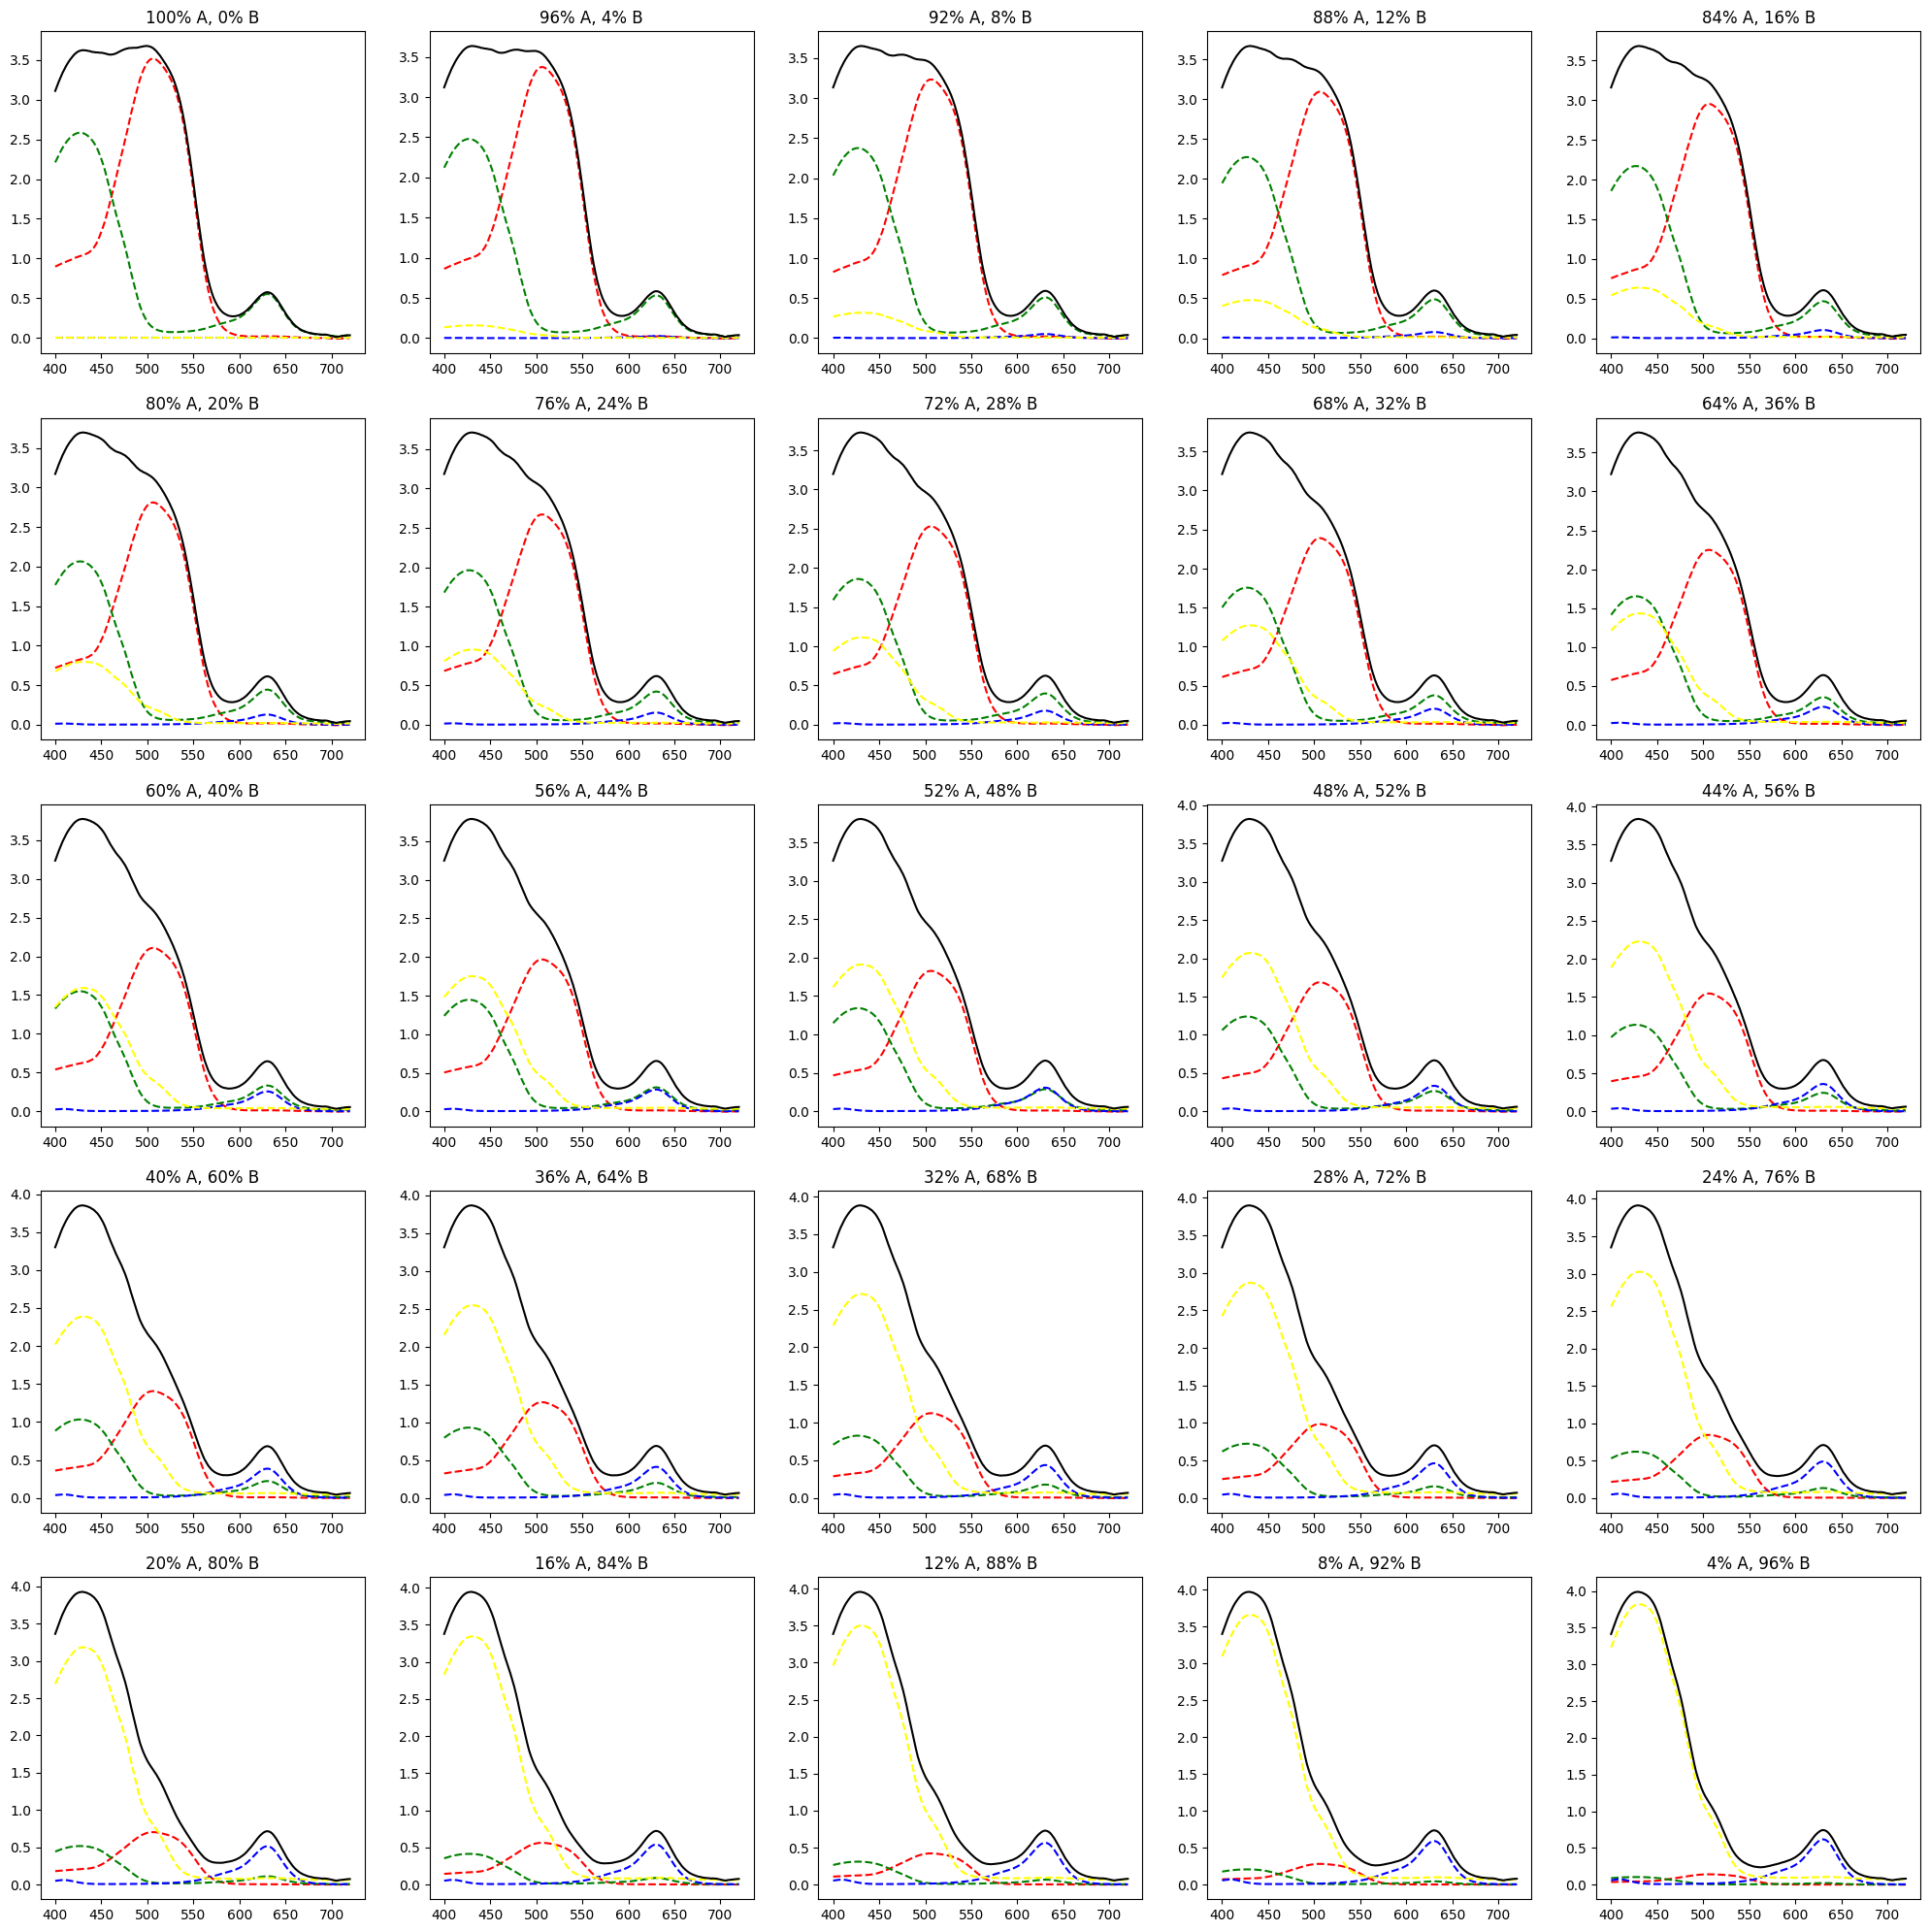

In [33]:
## Testing mixes for future imaging
fig = plt.figure(figsize = (10,12))
# HbO2
ax = plt.subplot(2, 2, 1)
ax.set_title('A Spectrum')
hbo2 = [('red', 12.5), ('green', 15)]
plot_mix_absolute(hbo2, ax, plt_raw=True, wave_range=(400, 720))

# dHb
ax = plt.subplot(2, 2, 2)
ax.set_title('B Spectrum')
dhb = [ ('blue', 1), ('yellow', 20.0)]
plot_mix_absolute(dhb, ax, plt_raw=True,  wave_range=(400, 720))
plt.show()
# 100 - 0% spO2
fig, axes = plt.subplots(5, 5, figsize = (25,25))
for ii in range(100, 0, -4):
    r = int(((100 - ii) / 4) // 5)
    c = int(((100 - ii) / 4) % 5)
    hbo2_per = ii / 100
    dhb_per = 1 - hbo2_per
    ax = axes[r, c]
    ax.set_title(f'{100 * hbo2_per:0.0f}% A, {100 * dhb_per:0.0f}% B')
    spo2_75 = [(color, hbo2_per * conc) for (color, conc) in hbo2] + [(color, dhb_per * conc) for (color, conc) in dhb]
    plot_mix_absolute(spo2_75, ax, plt_raw=True, wave_range=(400, 720))
plt.show()

Based on this graphcial test, we can determine the concentrations that give a reasonable $\mu_a$ for the stocks and dilutions. We will make a total stock of 15mL for each.

In [41]:
print('Stock A')
for color, conc in hbo2:
    print(f'{color.upper()} --> {15 * conc * 22 / 1000} mL into 15 mL milk')
    
print('\nStock B')
for color, conc in dhb:
    print(f'{color.upper()} --> {15 * conc * 22 / 1000} mL into 15 mL milk')


Stock A
RED --> 4.125 mL into 15 mL milk
GREEN --> 4.95 mL into 15 mL milk

Stock B
BLUE --> 0.33 mL into 15 mL milk
YELLOW --> 6.6 mL into 15 mL milk


For this study, we will use phantoms of 3mL and image at A percentages of 100%, 95%, 90%, 75%, 50%, 25%, 10%, 5%, 0%

In [37]:
T=0
for i, per in enumerate([100, 95, 90, 75, 50, 25, 10, 5, 0]):
    a = 3 * per / 100
    b = 3 * (100 - per) / 100
    T += (a+b)
    print(f'phantom {i+1} --> A stock: {a}. B stock: {b}')
print(f'Total milk volume: {T} (divided evenly between stocks)')

phantom 1 --> A stock: 3.0. B stock: 0.0
phantom 2 --> A stock: 2.85. B stock: 0.15
phantom 3 --> A stock: 2.7. B stock: 0.3
phantom 4 --> A stock: 2.25. B stock: 0.75
phantom 5 --> A stock: 1.5. B stock: 1.5
phantom 6 --> A stock: 0.75. B stock: 2.25
phantom 7 --> A stock: 0.3. B stock: 2.7
phantom 8 --> A stock: 0.15. B stock: 2.85
phantom 9 --> A stock: 0.0. B stock: 3.0
Total milk volume: 27.0 (divided evenly between stocks)


In [14]:
def read_json_metadata(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
        
    time = []
    integration = []
    wavelength = []
    intensity = []
    for d in data:
        dt = datetime.datetime(*[int(t) for t in d['AbsTime']])
        unix_timestamp = int(dt.timestamp())
        tau = float(d['ExpTime'])
        lam = int(d['Wavelength'])
        intense = float(d['AvgInt'])
        time.append(unix_timestamp)
        integration.append(tau)
        wavelength.append(lam)
        intensity.append(intense)
        
    indices = np.argsort(wavelength)
    return (np.asarray(time)[indices], 
            np.asarray(integration)[indices], 
            np.asarray(wavelength)[indices], 
            np.asarray(intensity)[indices],
            indices)

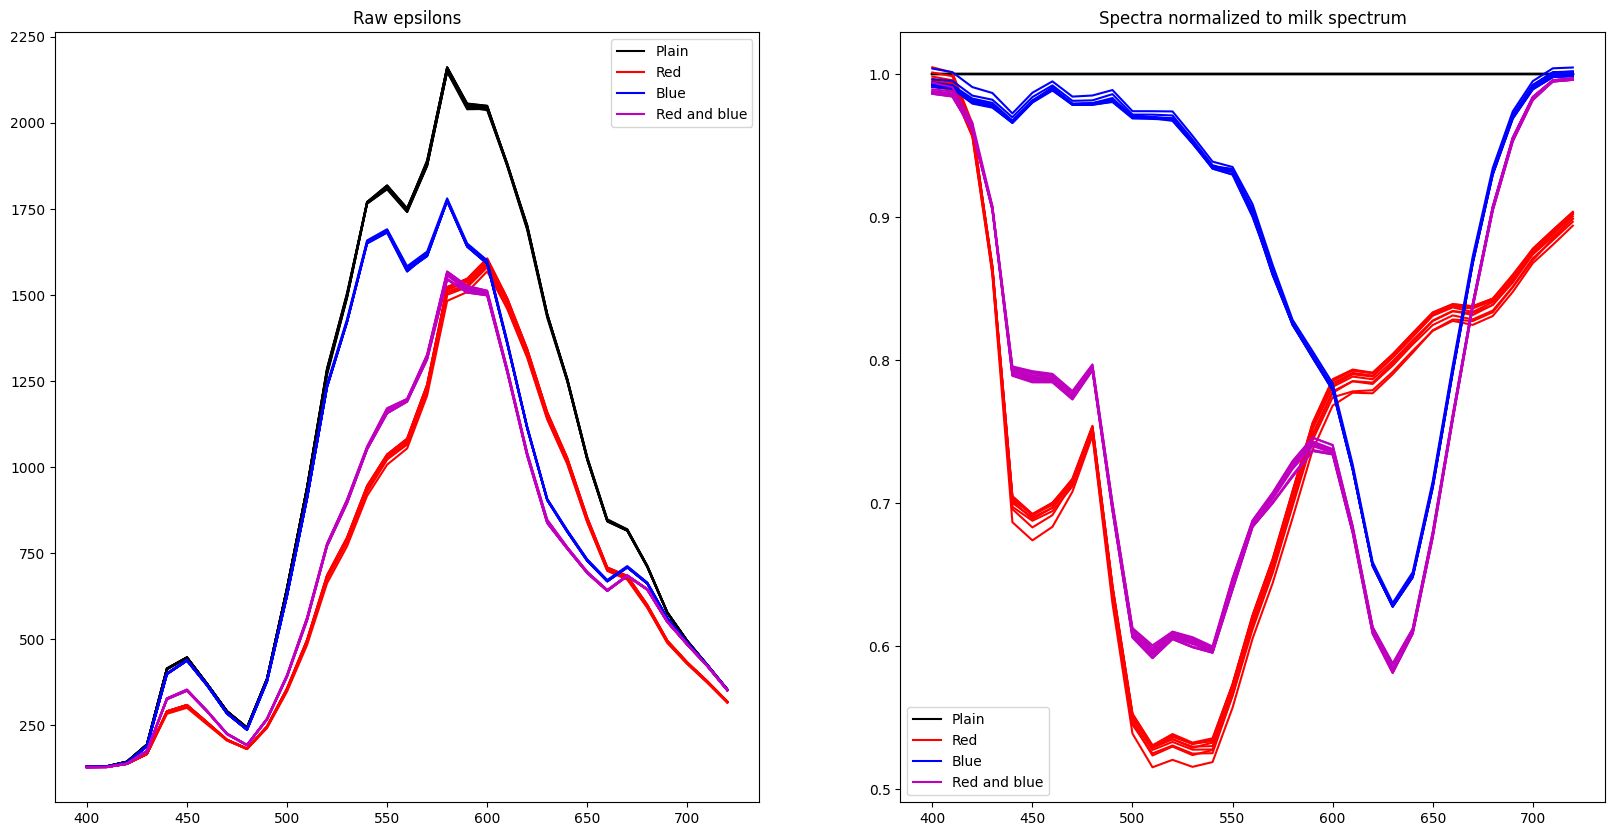

In [15]:
milk_paths = {'Plain': [r'D:\Jesse\phatnoms_02172025\milk', 'k'],
              'Red': [r'D:\Jesse\phatnoms_02172025\red_milk', 'r'],
              'Blue': [r'D:\Jesse\phatnoms_02172025\blue_milk', 'b'],
              'Red and blue': [r'D:\Jesse\phatnoms_02172025\purple_milk', 'm'] }

fig = plt.figure(figsize = (20,10))
raw_ax = plt.subplot(121)
diff_ax = plt.subplot(122)
out_data = {}
for label, (path, c) in milk_paths.items():
    raw_ax.plot([], [], label=label, color=c)
    diff_ax.plot([], [], label=label, color=c)
    for cycle in os.listdir(path):
        # Load settings data
        metadata_file = glob.glob(os.path.join(path, cycle, '*metadata.json'))[0]
        tim, integration, wavelength, intensity, indices = read_json_metadata(metadata_file)
        out_data[label] = intensity
        raw_ax.plot(wavelength, intensity, color=c)
        diff_ax.plot(wavelength, intensity / out_data['Plain'], color=c)
raw_ax.legend()
raw_ax.set_title('Raw epsilons')
diff_ax.legend()
diff_ax.set_title('Spectra normalized to milk spectrum')
plt.show()

### Beer's Law
$$
 A = \epsilon C l \\
 
 (a.u.) = \left[\frac{L}{mol \cdot{cm}}\right]\left[\frac{mol}{L}\right]\left[cm\right]
$$ 
We know $A$ and we have multiple dilutions (10, 15, and 45 uL of 5uL/mL into 3.4mL). We can let molarity be a variable,
$x$ and fit the relationship between absorption and relative concentration to find an extinction coefficient. The 
slope of the fit line should give the value of $\epsilon * l$. The standard cuvette $l = 1 cm$, so we can drop it out
and get $\epsilon$ in with units of M$^{-1}$cm$^{-1}$.
 
If fit quality is poor, as an alternative strategy, we can perform the full model fitting with the molarity persisting 
as a variable. The model outputs will then be interpreted relative to the stock concentration (i.e. as a factor of $x$).
To accomplish this, the extinction coefficients $\epsilon$ input into the model to calculate the absorption coefficient
$\mu_a$ will actually be the measured absorbance, $A$.

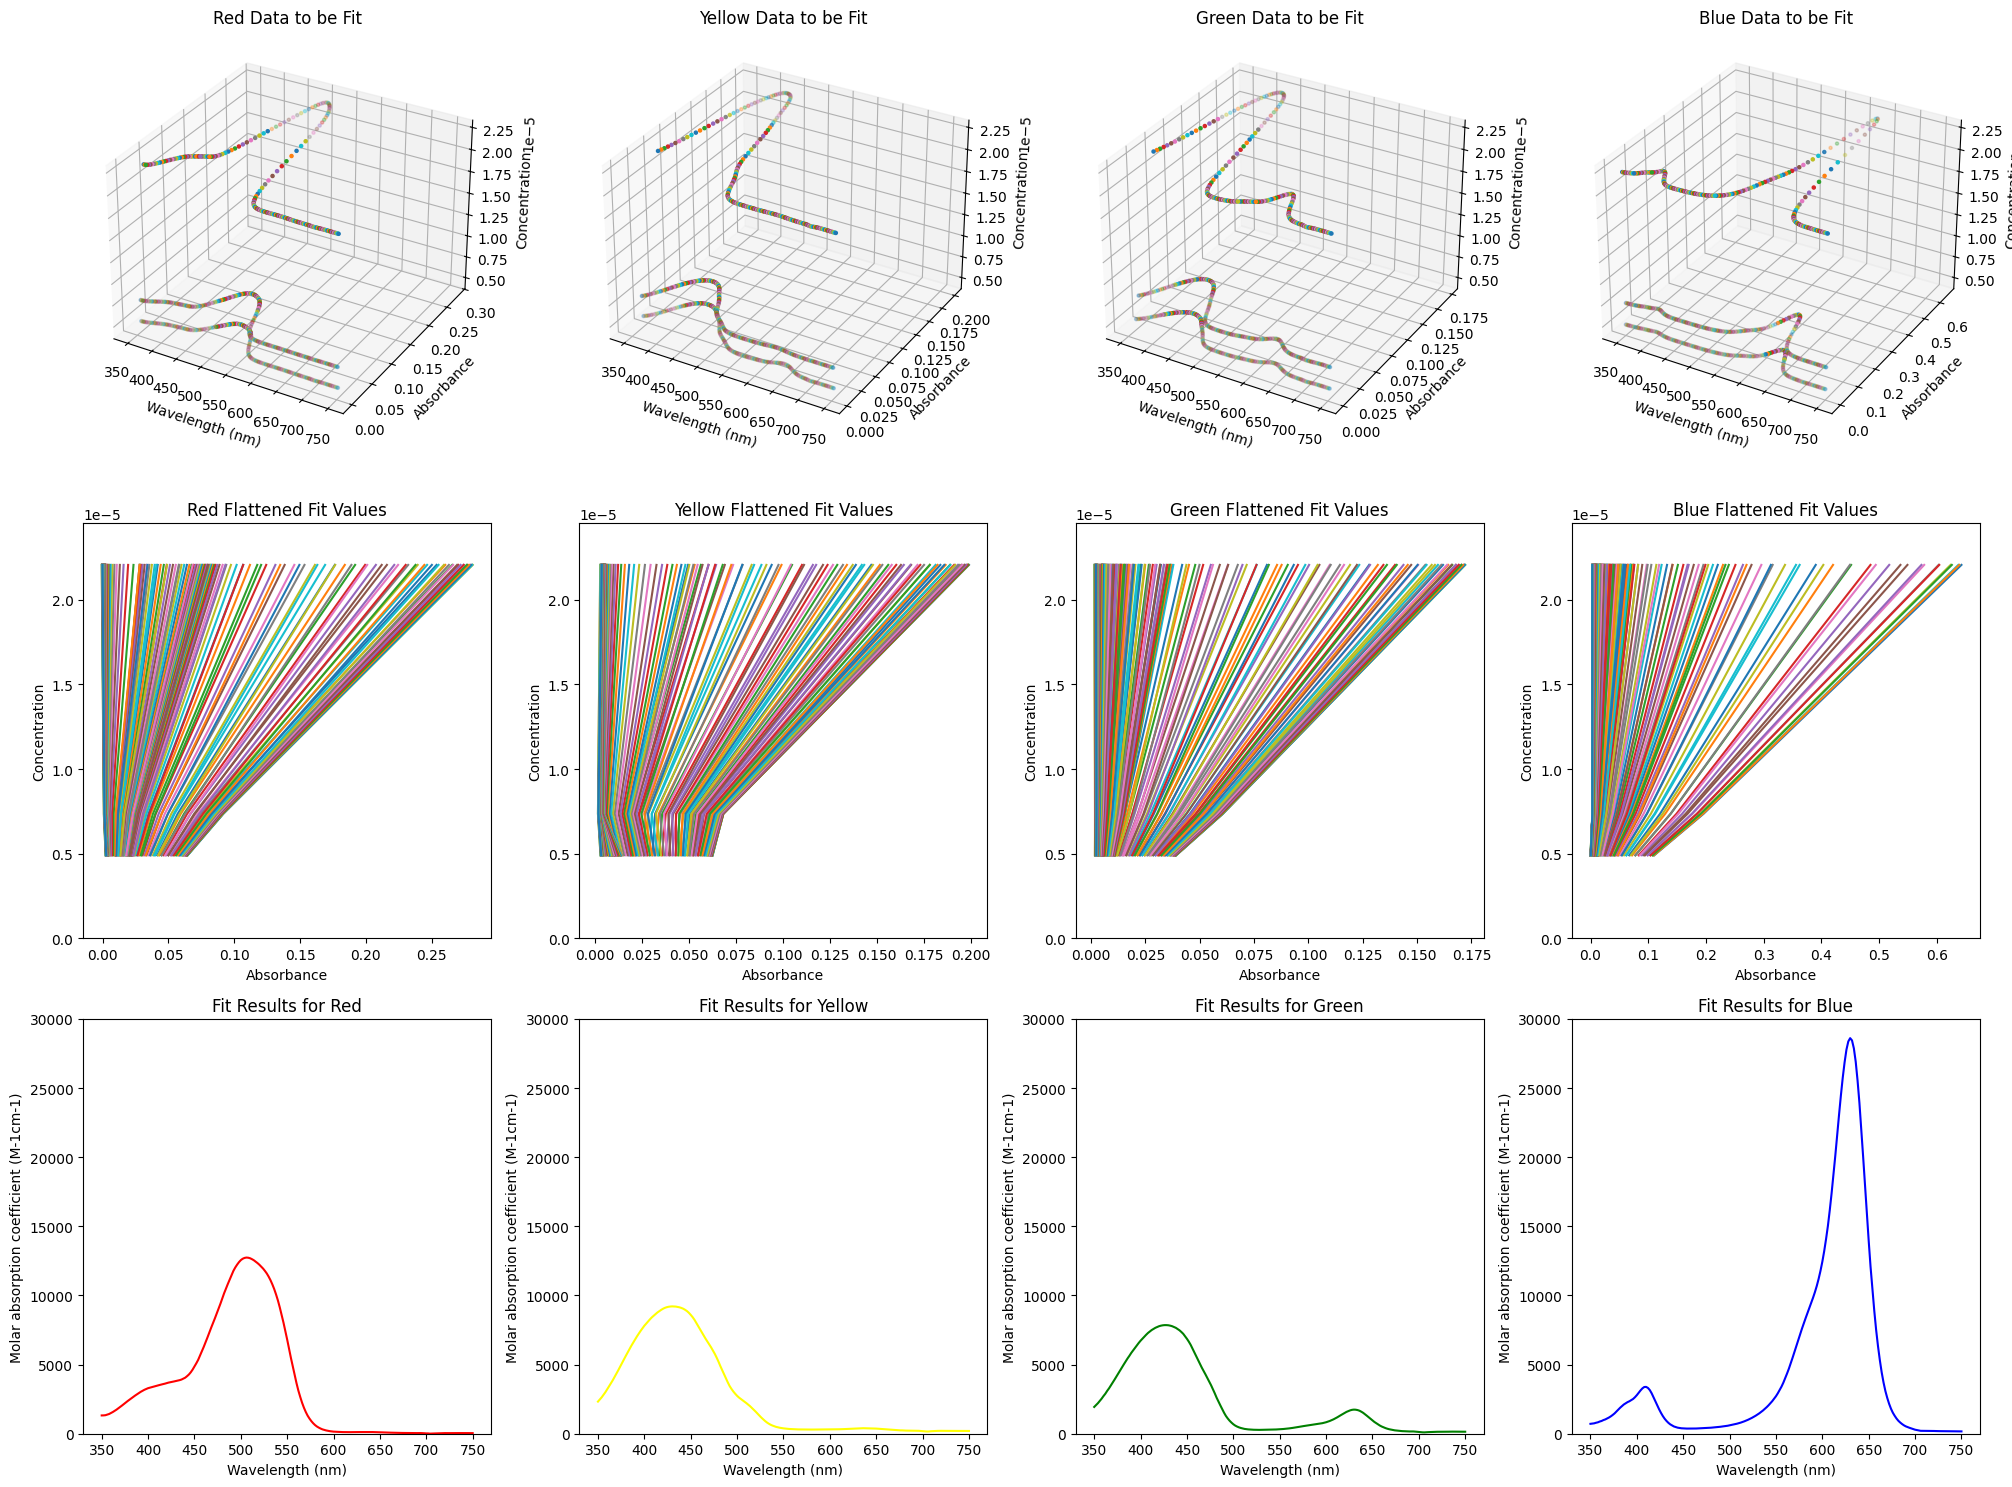

In [16]:
# Find molar extinction coefficients from food dyes
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
def beers(c, eps):
    return eps * c

def get_concentration(c):
    c = int(c.split('ul')[0])
    return (5e-3 * c * 1e-3) / (3 * 3.4)

colors = ['red', 'yellow', 'green', 'blue']
fig = plt.figure(figsize = (20,15))
extinction = {}
for r, color in enumerate(colors):
    ax1 = fig.add_subplot(3, 4, r + 1, projection='3d')
    ax2 = fig.add_subplot(3, 4, r + 5)
    ax3 = fig.add_subplot(3, 4, r + 9)
    data = spectra.loc[spectra['Color'] == color]
    wavelengths = data['Wavelength'].unique()
    extinction['Wavelength'] = wavelengths
    eps = []
    for wl in wavelengths:
        subdata = data.loc[data['Wavelength'] == wl]
        A = subdata['Absorption']
        c = subdata['Concentration'].apply(get_concentration)
        
        popt, _, _, mesg, ier = curve_fit(beers, c, A, full_output=True)
        eps.append(popt[0])
        if ier < 0 or ier > 4:
            print(mesg)
        
        # Plot all
        z = np.ones_like(c) * wl
        ax1.scatter(z, A, c, marker='.')
        ax2.plot(A, c, label=wl)

    ax3.plot(wavelengths, eps, color=color)
    extinction[color] = eps
    ax1.set_title(f'{color.capitalize()} Data to be Fit')
    ax1.set_xlabel('Wavelength (nm)')
    ax1.set_ylabel('Absorbance')
    ax1.set_zlabel('Concentration')
    ax2.set_title(f'{color.capitalize()} Flattened Fit Values')
    ax2.set_xlabel('Absorbance')
    ax2.set_ylabel('Concentration')
    ax2.set_ylim([0, get_concentration('50ul')])
    ax3.set_title(f'Fit Results for {color.capitalize()}')
    ax3.set_ylim([0, 30000])
    ax3.set_ylabel('Molar absorption coefficient (M-1cm-1)')
    ax3.set_xlabel('Wavelength (nm)')
plt.tight_layout()
plt.show()

In [17]:
conn = sqlite3.connect(r'C:\Users\jdivers\PycharmProjects\df_image_analysis\databases\hsdfm_data.db')
molar_coefficients = pd.DataFrame(extinction)
molar_coefficients.to_sql('food_coloring_molar_absorption_coefficients', con=conn, if_exists='replace', index=False)

DatabaseError: Execution failed on sql 'DROP TABLE "food_coloring_molar_absorption_coefficients"': database is locked

From the molar extinction coeffeficients, each food of teh original spectra can have the molar concentration determined by solving Beer's law for $C$:

$$
A = \epsilon C l \\

C = \frac{A}{\epsilon l} \\
$$

With the concentration solved for, the density of the fluid can be used to determine the mass of one mole of the solution as follows:

$$
C = \frac{n}{V} \\

n = \frac{m}{m_M} \\

m = \rho V_0 \\

C = \frac{\rho V_0}{m_M V} \\

m_M = \frac{\rho V_0}{V C} \\
$$

Where $V_0$ is the volume of the original food coloring solution in the test solution. This can be found for serial dilutions as follows:

$$
V_0 = V_\text{final} \prod_i^n c_i \\
$$

For example, when adding 10$\mu$L of a dilution of 5 $\mu$L of food coloring in 3 mL of water to the 3.4 mL cuvette:

$$
V_0 = 10 (\frac{5}{3})
$$

This can all be combined to get molar mass as follows:

$$
m_M = \frac{\rho \epsilon l V_{\text{final}} \prod_i^n c_i}{V A}
$$

This requires the additional measurement, $\rho$, which was taken by masing 1 mL of each food coloring.

### Mass of 1mL in g (i.e. density in g/mL)

|Red|Yellow|Green|Blue|
|:-:|:-:|:-:|:-:|
|1.0671|1.0752|1.1056|1.1019|

In [18]:
def get_epsilons(colors, wavelengths, conn=conn):
    colors = ['red', 'yellow', 'green', 'blue'] if colors == 'all' else colors
    colors = [colors] if isinstance(colors, str) else colors
    wavelengths = [wavelengths] if not np.iterable(wavelengths) else wavelengths
    # Fetch absorption spectra at appropriate wavelengths for all food colorings
    epsilons = []
    wl = [int(w) for w in wavelengths]
    c = conn.cursor()
    for color in colors:
        placeholder = ','.join('?' * len(wl)) 
        c.execute(f"SELECT {color} FROM food_coloring_molar_absorption_coefficients WHERE Wavelength IN ({placeholder})", wl)
        epsilon = c.fetchall()
        epsilons.append(tuple(e[0] for e in epsilon))
    return epsilons

In [19]:
rhos = {'red': 1.0671, 'yellow': 1.0752, 'green': 1.1056, 'blue': 1.1019}  # Mass of 1 mL in grams

def get_volume_0(c):
    c = int(c.split('ul')[0])
    return (5e-3 * c * 1e-3) / 3

colors = ['red', 'yellow', 'green', 'blue']
outputs = {}
V = 3.4
for r, color in enumerate(colors):
    data = spectra.loc[spectra['Color'] == color]
    wavelengths = data['Wavelength'].values
    mM = []
    for c in data.Concentration.unique():
        for wl in wavelengths:
            subdata = data.loc[data['Wavelength'] == wl].loc[data['Concentration'] == c]
            v0 = get_volume_0(c)
            epsilon = get_epsilons(color, wl, conn=conn)
            A = subdata['Absorption'].values
            rho = rhos[color] * 1000
            if A > 0:
                C = A / (epsilon)
                mM.append((rho * v0) / (C * V))
    outputs[color] = (np.mean(mM), np.std(mM))

This does not seem to work, so as an alternative to absolute valeus for these, everything can be measured relative to the input volume-to-volume concentrations. For robustness, a table will be created that has normalized absorptions for each volume-to-volume concentration (normalized meaning, the absoprtion will be divided by the concentration). The average absorbation of these normalized concentrations will be used moving forward. To be clear, the average absorption from this table will be designed to describe the absorption of a solution with 1 $\mu$L / mL of food coloring.

In [20]:
def get_concentration(c):
    c = int(c.split('ul')[0])
    return (5e-3 * c * 1e-3) / (3 * 3.4)  # Volume-to-volume in mL/mL

colors = ['red', 'yellow', 'green', 'blue']
normalized = {}
for r, color in enumerate(colors):
    data = spectra.loc[spectra['Color'] == color]
    wavelengths = data['Wavelength'].unique()
    conc = data['Concentration'].unique()
    normalized['Wavelength'] = wavelengths
    eps = []
    color_wise = np.zeros_like(wavelengths, dtype=np.float64)
    for c in conc:
        subdata = data.loc[data['Concentration'] == c]
        v0 = get_concentration(c)
        A = subdata['Absorption'].values
        a = A / v0 / 500 # Scales absorption to solution of 1mL in 500mL  
        normalized[f'{color}_{c}'] = a
        color_wise += a
    color_wise = color_wise / len(conc)
    normalized[f'{color}_Avg'] = color_wise
    

In [21]:
pd.DataFrame(normalized)

,Wavelength,red_10ul,red_15ul,red_45ul,red_Avg,yellow_10ul,yellow_15ul,yellow_45ul,yellow_Avg,green_10ul,green_15ul,green_45ul,green_Avg,blue_10ul,blue_15ul,blue_45ul,blue_Avg
0,350,3.985830,2.849336,2.554706,3.129957,7.507322,4.679542,4.500258,5.562374,4.467600,4.229110,3.802787,4.166499,1.064411,1.957685,1.392196,1.471430
1,352,4.036213,2.888830,2.557534,3.160859,7.854449,4.950182,4.815969,5.873533,4.731127,4.517267,4.087362,4.445252,1.095076,2.023481,1.429877,1.516145
2,354,4.051518,2.872973,2.588406,3.170966,8.204023,5.281043,5.114742,6.199936,4.986046,4.788723,4.347793,4.707521,1.113856,2.017201,1.464647,1.531902
3,356,4.129694,2.995998,2.669707,3.265133,8.616144,5.637472,5.485723,6.579780,5.282743,5.152850,4.679107,5.038233,1.200169,2.133712,1.544606,1.626162
4,358,4.237855,3.042891,2.764590,3.348445,9.085099,6.008997,5.851971,6.982022,5.606614,5.456157,4.998317,5.353696,1.250855,2.154354,1.613277,1.672829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,742,1.165954,0.417408,0.000769,0.528044,1.443647,0.543644,0.343334,0.776875,1.006308,0.728345,0.215157,0.649936,0.222635,0.895435,0.295660,0.471244
197,744,1.134020,0.408522,-0.000788,0.513918,1.433908,0.531406,0.337264,0.767526,1.000436,0.710605,0.210149,0.640397,0.221409,0.880872,0.293866,0.465382
198,746,1.158108,0.418943,0.000858,0.525969,1.428118,0.542564,0.339138,0.769940,1.011864,0.715178,0.213082,0.646708,0.219832,0.892990,0.290774,0.467865
199,748,1.132331,0.397422,-0.003029,0.508908,1.417421,0.529190,0.334120,0.760243,0.999555,0.699530,0.208112,0.635732,0.198655,0.875478,0.283225,0.452453


In [22]:
conn = sqlite3.connect(r'C:\Users\jdivers\PycharmProjects\df_image_analysis\databases\hsdfm_data.db')
norm_coefficients = pd.DataFrame(normalized)
norm_coefficients.to_sql('food_coloring_normalized_absorption_coefficients', con=conn, if_exists='replace', index=False)

DatabaseError: Execution failed on sql 'DROP TABLE "food_coloring_normalized_absorption_coefficients"': database is locked

In [30]:
def get_normalized_absorption(colors, wavelengths, conn=conn):
    colors = ['red', 'yellow', 'green', 'blue'] if colors == 'all' else colors
    colors = [colors] if isinstance(colors, str) else colors
    wavelengths = [wavelengths] if not np.iterable(wavelengths) else wavelengths
    # Fetch absorption spectra at appropriate wavelengths for all food colorings
    coefficients = []
    wl = [int(w) for w in wavelengths]
    c = conn.cursor()
    for color in colors:
        placeholder = ','.join('?' * len(wl))
        c.execute(f"SELECT {color}_Avg FROM food_coloring_normalized_absorption_coefficients WHERE Wavelength IN ({placeholder})", wl)
        coefficient = c.fetchall()
        coefficients.append(tuple(coeff[0] for coeff in coefficient))
    return coefficients

ValueError: too many values to unpack (expected 2)

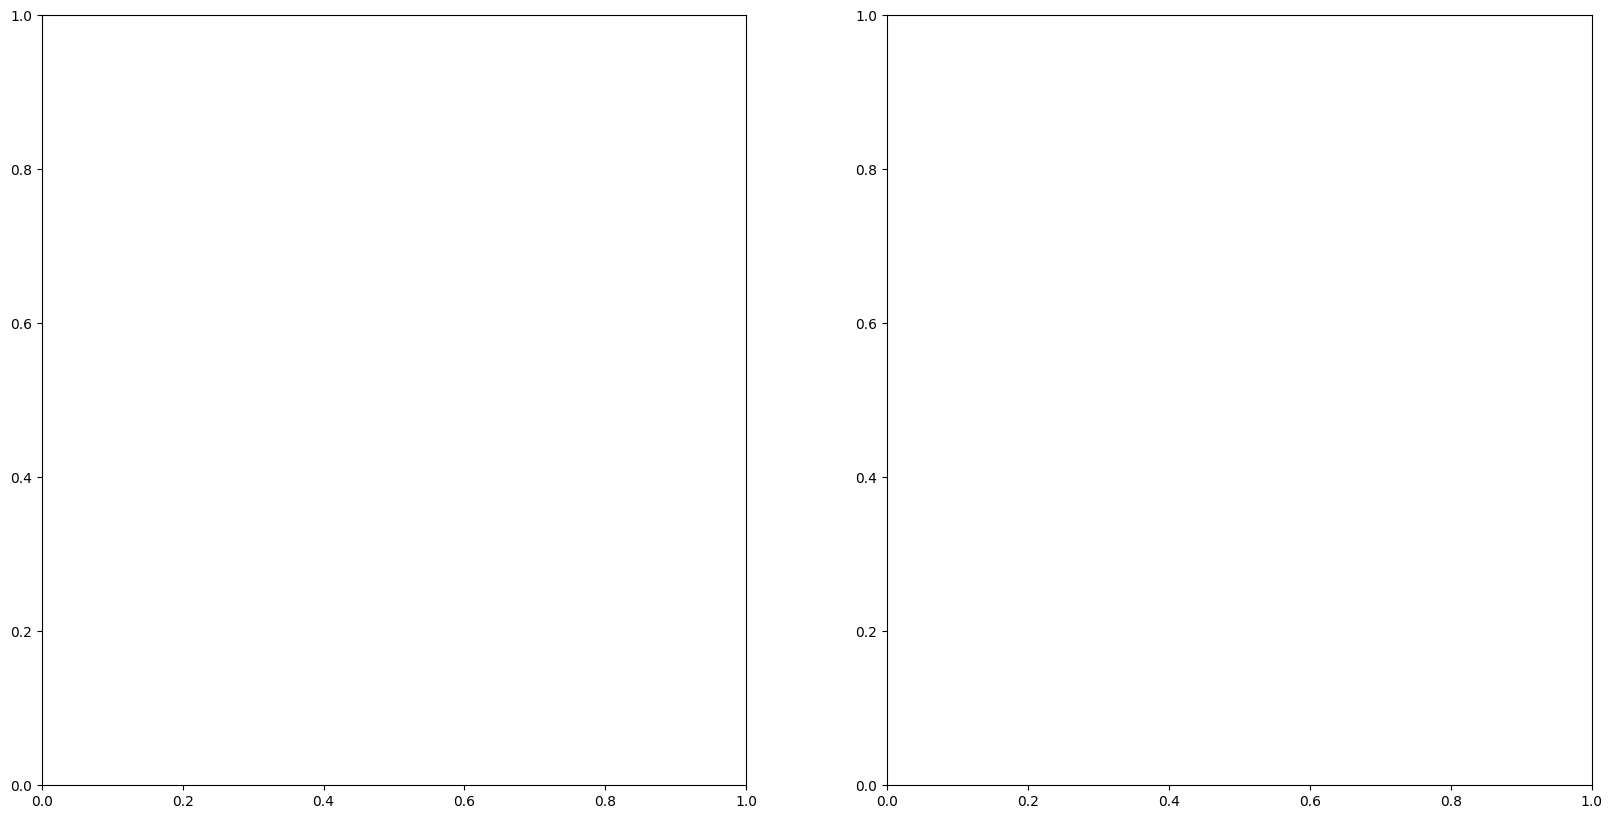

In [31]:
fig = plt.figure(figsize = (20,10))
raw_ax = plt.subplot(121)
diff_ax = plt.subplot(122)
out_data = {}
for label, (path, c) in milk_paths.items():
    raw_ax.plot([], [], label=label, color=c)
    if 'Plain' in out_data:
        diff_ax.plot([], [], label=label, color=c)
    intensities = []
    for cycle in os.listdir(path):
        # Load settings data
        metadata_file = glob.glob(os.path.join(path, cycle, '*metadata.json'))[0]
        tim, integration, wavelength, intensity, indices = read_json_metadata(metadata_file)
        intensities.append(intensity)
        raw_ax.plot(wavelength, intensity, color=c)
        if 'Plain' in out_data:
            diff_ax.plot(wavelength, intensity / out_data['Plain'] , color=c)
    intensity = np.mean(intensities, axis=0)
    out_data[label] = intensity
raw_ax.legend()
raw_ax.set_title('Raw absorbance')
diff_ax.legend()
diff_ax.set_title('Plain Milk / Sample')
plt.show()

In [35]:
conn = sqlite3.connect(r'C:\Users\jdivers\PycharmProjects\df_image_analysis\databases\hsdfm_data.db')
data = pd.read_sql('SELECT * FROM food_coloring_molar_absorption_coefficients', con=conn)

In [36]:
from my_modules.image_processing.models import calculate_mus
from my_modules.monte_carlo import lookup
# Image dirs to analyze
milk_paths = {'Plain': r'D:\Jesse\phatnoms_02172025\milk\cycle1',
              'Blue+Green': r'D:\Jesse\phatnoms_02172025\blue25_green25\cycle1',
              'Red+Yellow+Blue': r'D:\Jesse\phatnoms_02172025\red25_yellow25_blue_10\cycle1',
              'Red+Yellow+Green+Blue': r'D:\Jesse\phatnoms_02172025\red50_yellow25_blue10_green10\cycle1'
              }
data = pd.DataFrame(index=milk_paths.keys(), 
                    columns=['Wavelength', 'Intensity', 'IntegrationNorm', 'RefNorm', 'a', 'b', 'c', 'alphas', 'Chi2']
                    )
for label, milk_path in milk_paths.items():
    # Load settings data
    metadata_file = glob.glob(os.path.join(milk_path, '*metadata.json'))[0]
    tim, integration, wavelength, intensity, indices = read_json_metadata(metadata_file)
    data.loc[label, 'Wavelength'] = wavelength
    data.loc[label, 'Intensity'] = intensity
    data.loc[label, 'IntegrationNorm'] = intensity / integration
    if not np.all(np.isnan(data.loc['Plain', 'IntegrationNorm'])):
        ref_norm = intensity / data.loc['Plain', 'IntegrationNorm']
    else:
        ref_norm = intensity / intensity
    data.loc[label, 'RefNorm'] = ref_norm

In [37]:
c = conn.cursor()

In [43]:
from scipy.interpolate import CubicSpline, RegularGridInterpolator
from my_modules.monte_carlo import simulate, System, OpticalMedium


def lookup2(mu_s, mu_a, g, depth,
           conn=conn, simulation_id=None, save_sim=True, force_simulate=False, skip_simulation=False):
    
    assert not (force_simulate and skip_simulation), 'It is ambiguous to set both skip_simulation and force_simulate to TRUE.'
    
    # If simulation_id is NONE, default to most recent
    if simulation_id is None:
        c.execute("SELECT * FROM mclut_simulations ORDER BY id DESC LIMIT 1")
        simulation_id = c.fetchone()[0]

    # Fetch available parameters within the simulation_id
    c.execute("""
        SELECT mu_s, mu_a, g, depth, reflectance 
        FROM mclut
        WHERE simulation_id = ?
    """, (simulation_id,))

    rows = c.fetchall()

    # Check for exact matches
    exact_match = None
    for row in rows:
        if row[0] == mu_s and row[1] == mu_a and row[2] == g and row[3] == depth:
            exact_match = row
            break

    if exact_match:
        return exact_match[-1]  # Return the result value for the exact match
    
    # Removed forced simulations from interpolation data
    c.execute("""
        SELECT mu_s, mu_a, g, depth, reflectance 
        FROM mclut
        WHERE simulation_id = ? AND forced = False
    """, (simulation_id,))
    rows = c.fetchall()

    # If no exact match, check if parameters are within the bounds for interpolation
    mu_s_vals, mu_a_vals, g_vals, depth_vals, ref_vals = zip(*rows)

    # Find nearest bounds for interpolation. Here we assume cubic spline interpolation for all parameters.
    
    if not force_simulate:
        # Get data into a regular grid 
        x = np.unique(mu_s_vals)
        y = np.unique(mu_a_vals)
        z = np.asarray(ref_vals).reshape(len(x), len(y))
        
        # Interpolation
        spline = RegularGridInterpolator((x, y), z, method='cubic', bounds_error=False, fill_value=None)
        interpolated_ref = spline((mu_s, mu_a))
        return interpolated_ref.item()

    # If query is out of bounds or if force_simulate is True, simulate the result
    elif not skip_simulation:
        print(f'Simulating for mu_s={mu_s}, mu_a={mu_a}, g={g}, depth={depth}')
        # Get matching simulation parameters
        c.execute("""SELECT photon_count, water_n, water_mu_s, water_mu_a, tissue_n, surroundings_n, recursive
        FROM mclut_simulations WHERE id = ?""", (simulation_id,))
        params = c.fetchone()

        # Re-create system
        di_water = OpticalMedium(n=params[1], mu_s=params[2], mu_a=params[3], g=0, type='di_water')
        tissue = OpticalMedium(n=params[4], mu_s=mu_s, mu_a=mu_a, g=g, type='tissue')
        system = System(di_water, 0.01, tissue, depth, surrounding_n=params[5])

        _, R, _ = simulate(system, n=params[0], recurse=params[6])

        # Insert the new simulation into the database
        if save_sim:
            c.execute("""
                INSERT INTO mclut (simulation_id, mu_s, mu_a, g, depth, transmission, reflectance, absorption, forced)
                VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
            """, (simulation_id, mu_s, mu_a, g, depth, T, R, A, True))
            conn.commit()
        
        return R


ValueError: x and y must have same first dimension, but have shapes (33,) and (201,)

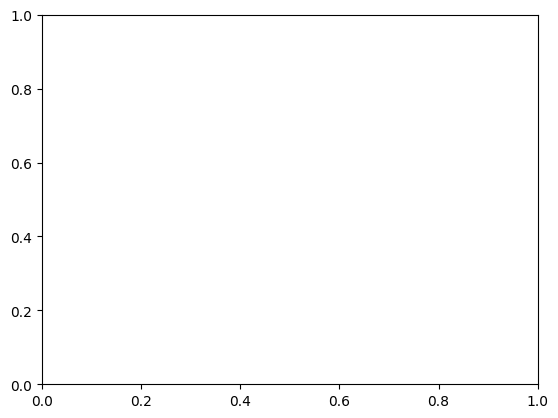

In [44]:
for coef in coeffs:
    plt.plot(wavelengths, coef)
plt.show()

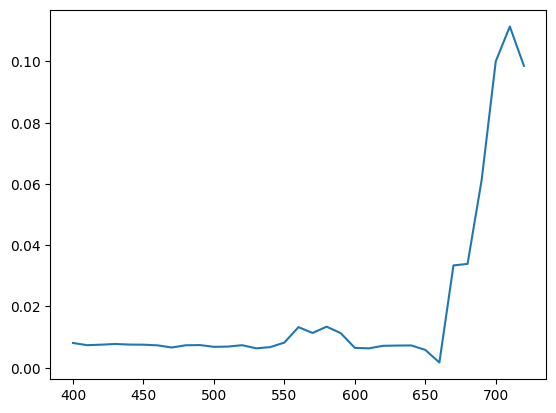

In [45]:
x0 = np.random.random_sample(6)
a, b = x0[0:2]
ci = x0[2:]
simulation_id = 15
g = 0.9
d = float('inf')
coeffs = get_normalized_absorption('all', wavelengths, conn=conn)
mu_s, mu_a, wl = calculate_mus(10 * a, b, ci, epsilons=coeffs, wavelength=wavelengths, wavelength0=700, force_feasible=False)
Rm = []
for s, a in zip(mu_s, mu_a):
    Rm.append(lookup2(s, a, g, d, conn=conn, simulation_id=18, save_sim=False))
plt.plot(wavelengths, Rm)
plt.show()

C:\Users\jdivers\PycharmProjects\df_image_analysis\.venv\Lib\site-packages\scipy\optimize\_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


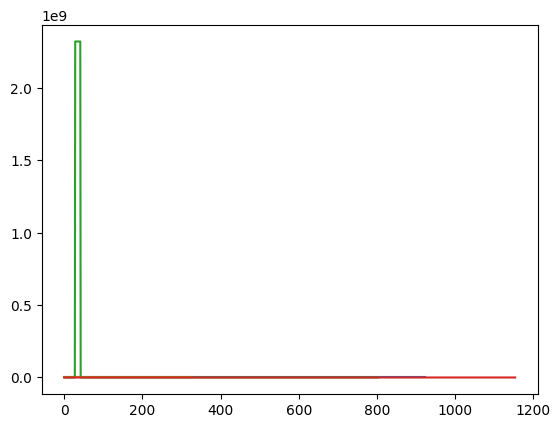

In [46]:
bounds = 6 * [(0, float('inf'))]
results = []
for d in data.itertuples():
    wavelengths = d.Wavelength
    Re = d.RefNorm
    loss = []
    
    # Setup objective function
    # x: a, b, [c_red, c_yellow, c_green, c_blue] 
    def objective(x, wavelengths):
        # Extract fit parameters
        a, b = x[0:2]
        ci = x[2:]
        simulation_id = 18
        g = 0.9
        d = float('inf')
        
        # Get absorption coefficients
        epsilons = get_normalized_absorption('all', wavelengths, conn=conn)
        
        # Calculate coefficients from concentrations
        mu_s, mu_a, wl = calculate_mus(10 * a, b, ci, epsilons=epsilons, wavelength=wavelengths, wavelength0=700, force_feasible=False)
        mu_a /= 2
        # Check MCLUT
        Rm = []
        for mus, mua in zip(mu_s, mu_a):
            Rm.append(lookup2(mus, mua, g, d, conn=conn, simulation_id=simulation_id, skip_simulation=True, save_sim=False))
        if not np.any([R is not None for R in Rm]):
            return 1e6
        Rm = np.asarray(Rm)
        mask = np.where(Rm)[0]
        # print(len(mask) / len(Rm))
        loss.append(np.sum((Rm[mask] -  Re[mask]) ** 2))
        return loss[-1]

    x0 = np.random.random_sample(6)
    result = minimize(objective, x0, args=wavelengths, method='trust-constr', bounds=bounds, options={'maxiter': 5000})
    plt.plot(loss)
    results.append(result)

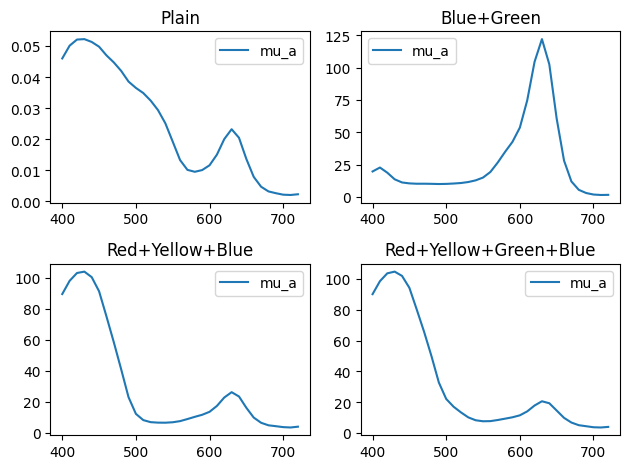

In [47]:
fig = plt.figure()
for i, (d, result) in enumerate(zip(data.itertuples(), results)):
    ax = fig.add_subplot(2, 2, i + 1)
    coeffs = get_normalized_absorption('all', d.Wavelength, conn)
    mu_s, mu_a, wavelengths = calculate_mus(10 * result.x[0], result.x[1], 3 * result.x[2:], wavelength=d.Wavelength, epsilons=coeffs, wavelength0=700)
    # ax.plot(d.Wavelength, mu_s, label='mu_s')
    ax.plot(d.Wavelength, mu_a, label='mu_a')
    # ax.plot(d.Wavelength, mu_a + mu_s, label='mu_t')
    ax.set_title(d.Index)
    ax.legend()
plt.tight_layout()
plt.show()

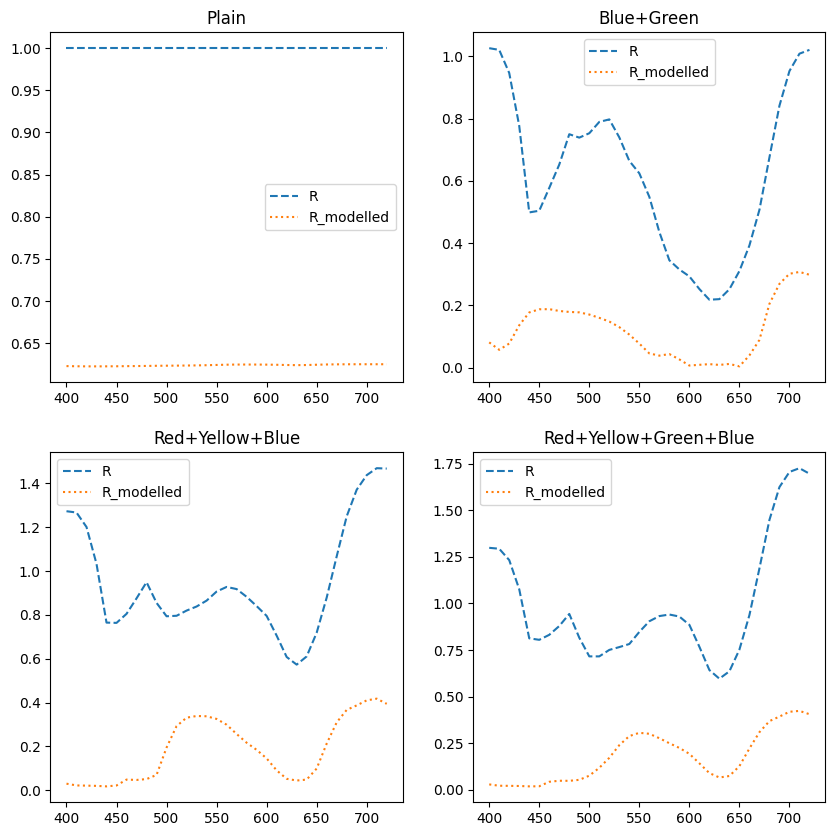

In [50]:
fig = plt.figure(figsize = (10,10))
correction_factor = []
for i, (result, d) in enumerate(zip(results, data.itertuples())):
    ax = fig.add_subplot(2,2,i+1)
    ax.plot(d.Wavelength, d.RefNorm, label='R', linestyle='--')
    coeffs = get_normalized_absorption('all', d.Wavelength, conn=conn)
    mu_s, mu_a, wavelengths = calculate_mus(result.x[0], result.x[1], result.x[2:], wavelength=d.Wavelength, epsilons=coeffs, wavelength0=700)
    R = []
    for mu_s, mu_a in zip(mu_s, mu_a):
        R.append(lookup2(mu_s, mu_a, 0.85, float('inf'), conn=conn, simulation_id=18, skip_simulation=True))
    correction_factor.append((d.RefNorm - 1) / np.array(R))
    ax.plot(d.Wavelength, R, label='R_modelled', linestyle='dotted')
    ax.set_title(d.Index)
    ax.legend()
plt.show()

In [51]:
md_table

' # Results from MCLUT Fit\n| Mix | a | b | red | yellow | green | blue | total | actual |\n|:---:|:-:|:-:|:---:|:------:|:-----:|:----:|:-----:|:------:|\n'

In [57]:
from IPython.display import display, Markdown
md_table = f""" # Results from MCLUT Fit
| Mix | a | b | red | yellow | green | blue | total | actual |
|:---:|:-:|:-:|:---:|:------:|:-----:|:----:|:-----:|:------:|
"""
ratio = {'Plain': (0, 0, 0, 0),
         'Blue+Green': (0, 0, 25, 25),
         'Red+Yellow+Blue': (25, 25, 0, 10),
         'Red+Yellow+Green+Blue': (50, 25, 10, 10),
          }
for d, result in zip(data.itertuples(), results):
    total = np.sum(result.x[2:])
    r = result.x[2:] / total
    r_actual = np.array(ratio[d.Index] / np.sum(ratio[d.Index]))
    md_table += f"""|{d.Index}|{result.x[0]:0.2f}|{result.x[1]:0.2f}|{r[0]:0.2f}|{r[1]:0.2f}|{r[2]:0.2f}|{r[3]:0.2f}|{total:0.2f}|{r_actual}\n"""
display(Markdown(md_table))

C:\Users\jdivers\AppData\Local\Temp\ipykernel_6016\1868833674.py:14: RuntimeWarning: invalid value encountered in divide
  r_actual = np.array(ratio[d.Index] / np.sum(ratio[d.Index]))


 # Results from MCLUT Fit
| Mix | a | b | red | yellow | green | blue | total | actual |
|:---:|:-:|:-:|:---:|:------:|:-----:|:----:|:-----:|:------:|
|Plain|10.52|0.00|0.28|0.26|0.39|0.07|0.00|[nan nan nan nan]
|Blue+Green|3.66|1.78|0.06|0.12|0.00|0.82|0.41|[0.  0.  0.5 0.5]
|Red+Yellow+Blue|8.26|0.69|0.00|0.00|1.00|0.00|0.94|[0.41666667 0.41666667 0.         0.16666667]
|Red+Yellow+Green+Blue|8.73|0.59|0.00|0.34|0.66|0.00|0.86|[0.52631579 0.26315789 0.10526316 0.10526316]


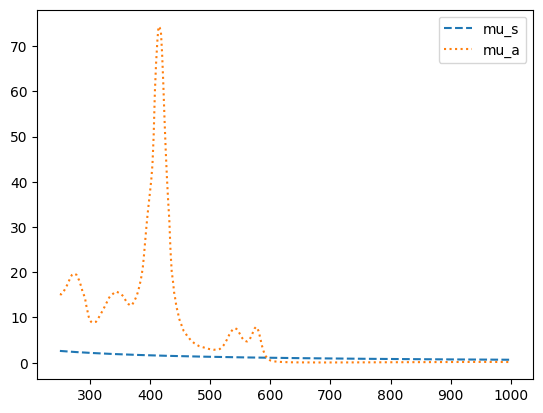

In [215]:
c = conn.cursor()
c.execute(f"SELECT * FROM hb_spectra")
wl, hbo2, dhb = zip(*c.fetchall())
# tHb = 4 and sO2 = 0.98
tHb = 4
tHb /= 64500  # molar mass of hemoglobin
sO2 = 0.98

mu_s, mu_a, wl = calculate_mus(a=1,
                  b=1,
                  ci=(tHb * sO2, tHb * (1 - sO2)),
                  epsilons=(hbo2, dhb),
                  wavelength=wl, wavelength0=650)
plt.plot(wl, mu_s, label='mu_s', linestyle='--')
plt.plot(wl, mu_a, label='mu_a', linestyle='dotted')
plt.legend()
plt.show()

### Finding the molar mass of the food colorings

In the case of hemoglobin being dissolved into solution, finding the molar mass from the absorption and molar absorption coefficient is trivial, because the mass of the absorber in solution is known (typically, $ \frac{\text{mg}}{\text{mL}} $). With a known mass concentration, absorption for that concentration, and molar absorption coefficient, the molar mass can be found as follows: 

$$
A = \mu_a l = \epsilon C l \therefore \\

\mu_a = \epsilon C \\

C = \frac{n}{V} \text{ where } n \text{ is the number of moles and } V \text{ is the volume of solution.} \\

n = \frac{m}{m_M} \text{ where } m_M \text{ is the molar mass.} \\

\therefore \\

\mu_A = \epsilon \frac{m}{m_M V} \\

m_M = \frac{\epsilon m}{\mu_A V} \\
$$

In the case of food coloring, however, we do not know the mass of the absorbers, nor the concentrations of absorbers in the original food coloring solutions (which are mixes of absorbing and non absorbing species). To simplify the problem, then, we can treat the whole solution as an absorber (effectively, performeing a weighted average of teh  averagein the absorbance of all the species within the original solution). By massing a known volume of the solution, this equation can be solved for the food coloring to find the density, this equation can be solved for food coloring as well with a simple manipulation:

$$
m = \rho V_0 \text{ where } V_0 \text{ is the total volume of the original solution used in the absorbance measurement.} \\

m_M = \frac{\epsilon \rho V_0}{\mu_A V} \\
$$
For simplicty, $\frac{V_0}{V}$ can be represented by $c$, the volume-for-volume concentration of the absorbing solution in the cuvette. To minimize error, we can solve this using a linear regression for all the wavelengths of measure by rearranging into a linear form with $\mu_a$ as the dependent variable and $c$ as the independent variable:

$$
\mu_a = \frac{\epsilon \rho}{m_M} c \\

\text{slope} = \frac{\epsilon \rho}{m_M} \\

\therefore \\ 

m_M = \frac{\epsilon \rho}{\text{slope }} \\
$$

In [217]:
# Find molar mass from food dyes
rhos = {'red': 1.0671, 'yellow': 1.0752, 'green': 1.1056, 'blue': 1.1019}  # Mass of 1 mL in grams
V = 3.4

# Load raw spectra in dataframe
spectra = pd.read_sql('SELECT * FROM food_coloring_spectra', conn)

colors = ['red', 'yellow', 'green', 'blue']
extinction = {}
results = []
for r, color in enumerate(colors):
    
    # Get color specific data from database
    data = spectra.loc[spectra['Color'] == color]
    wavelengths = data['Wavelength'].unique()
    molar_masses = []
    for wl in wavelengths:
        subdata = data.loc[data['Wavelength'] == wl]
        mu_a = subdata['Absorption']
        eps = np.asarray(get_epsilons(color, wl, conn=conn)[0])  # Get from db
        c = subdata['Concentration'].apply(get_concentration)
        rho = rhos[color] * 1000  # convert to g / L
    
        def obj(conc, mM):
            return eps * rho * conc / mM
        
        popt, _, _, mesg, ier = curve_fit(obj, c, mu_a, full_output=True)
        molar_masses.append(popt[0])
        if ier < 0 or ier > 4:
            print(mesg)
    results.append(np.mean(molar_masses))
    print(f'Molar mass of {color} = {results[-1]}')

Molar mass of red = 1067.0999952392585
Molar mass of yellow = 1075.200000346138
Molar mass of green = 1105.6000001006505
Molar mass of blue = 1101.900000007915
